## Load data

For the following Early time series classification models let's load some univariate data

In [5]:
from fedot_ind.api.utils.path_lib import PROJECT_PATH
import sys
import os

if not os.getcwd() == PROJECT_PATH:
    os.chdir(PROJECT_PATH)


In [6]:
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot_ind.core.architecture.settings.computational import backend_methods as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [7]:
from fedot_ind.tools.loader import DataLoader

def load_univariate_classification():
    dl = DataLoader('Lightning7')
    (train_series, train_labels), (test_series, test_labels) = dl.load_data()
    train_data = InputData(idx=np.arange(test_series.shape[1]),
                           features=train_series.values,
                           target=train_labels,
                           task=Task(TaskTypesEnum.classification),
                           data_type=DataTypesEnum.table)
    test_data = InputData(idx=np.arange(test_series.shape[1]),
                           features=test_series.values,
                           target=test_labels,
                           task=Task(TaskTypesEnum.classification),
                           data_type=DataTypesEnum.table)
    return train_data, test_data


2024-07-22 13:42:16,908 - PyTorch version 2.2.2 available.


In [8]:
train_data, test_data = load_univariate_classification()
print(f'Shape of train_data.features: {train_data.features.shape}\ntest_data shape: {test_data.features.shape}')
print('Number of classes:', len(np.unique(train_data.target)))

Shape of train_data.features: (70, 319)
test_data shape: (73, 319)
Number of classes: 7


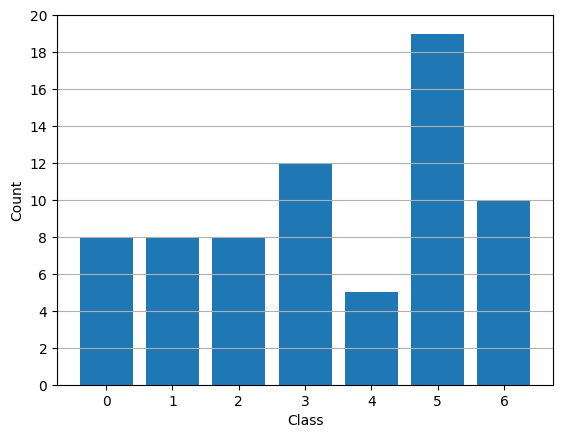

In [4]:
plt.bar(*(np.unique(train_data.target, return_counts=True)))
plt.ylabel('Count')
plt.xlabel('Class')
plt.yticks(np.arange(0, 21, 2));
plt.grid(axis='y');

## Standalone models

All the models presented below share the same principle of functioning:

Since there's no way for many classifiers to support inference for different data sizes, the basic Early ETSC class implements fitting of multiple slave estimators according to the specified intervals (by *interval_percentage* key word) on time series instance. Depending on the length of features passed and *prediction_mode* parameter the appropriate subset if classifiers is selected and inference is committed. The details of fitting and inference vary drastically.  

In [5]:
from fedot_ind.core.models.early_tc import base_early_tc as BASE_ETC
from importlib import reload

Xtr, ytr = train_data.features.squeeze(), train_data.target
Xte, yte = test_data.features.squeeze(), test_data.target

INTEVAL_PERCENTAGE = 10
earliness = np.round((1 - np.arange(0, Xtr.shape[0], int(INTEVAL_PERCENTAGE * Xtr.shape[0] / 100)) / Xtr.shape[0]) * 100)


In [198]:
from fedot_ind.core.metrics.metrics_implementation import ETSCPareto

def eval_param_influence(model, prm_name, options, **model_kw):
    r = {}
    for option in tqdm(options, desc='Options'):
        model_ = model({prm_name: option, **model_kw})
        model_.fit(Xtr, ytr)
        labels, scores = model_.predict(Xte)
        r[option] = ETSCPareto(yte, labels.astype(int), scores, reduce=False, metric_list=('accuracy',)).metric().copy()
    return r

def plot_changes(result_metrics: dict, param_name='', height=3):
    fig, axes = plt.subplots(1, len(result_metrics), figsize=(len(result_metrics) * height, height * 1.2))
    for i, (param_val, values) in enumerate(result_metrics.items()):
        n = len(values.accuracy)
        earliness = np.round((1 - np.arange(n)/ n) * 100)
        axes[i].plot(values.robustness, 
                    values.accuracy, c='k', alpha=0.4)
        scatter = axes[i].scatter(x=values.robustness, 
                        y=values.accuracy,
                        c=earliness,
                        cmap='plasma'
                        )
        axes[i].set_xlim((-0.05, 1.05))
        axes[i].set_ylim((-0.05, 1.05))
        axes[i].set_xticks(np.linspace(0, 1, 6))
        axes[i].set_yticks(np.linspace(0, 1, 6))
        axes[i].grid('all')
        axes[i].set_title(f'{param_name} = {param_val}')
        if i == 0: 
            legend1 = axes[i].legend(*scatter.legend_elements(alpha=0.6),
                        loc='best',
                        title="earliness, %",
                        ncols=2,
                        borderaxespad=0
                        )
            axes[i].add_artist(legend1)
        
    fig.supylabel('accuracy')
    fig.supxlabel('robustness')
    fig.tight_layout()



### Probability Thresholding

Probability Thresholding executes the simpliest mode of prediction:

Firstly, the number of matching consecutive predictions is avaluated. If number of classifiers predicted the same label exceeds the specified *consecutive_predictions* parameter, the classification is done confidently. 

Otherwise the predicted probability is compared to the *probability_threshold*. And if it is not below it, the prediction is accepted.

In [ ]:
from fedot_ind.core.models.early_tc import prob_threshold as PROB_THR

cons_preds = [1, 3, 5, 7]
r_pthr = eval_param_influence(PROB_THR.ProbabilityThresholdClassifier,
                               'consecutive_predictions', cons_preds, probability_threshold=0.8,
                               prediction_mode='all', interval_percentage=INTEVAL_PERCENTAGE) 

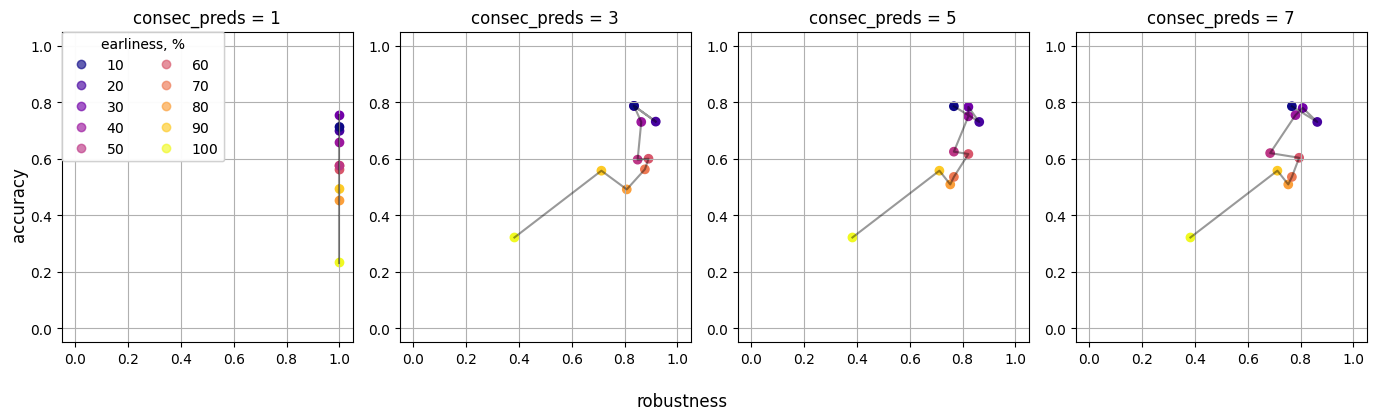

In [199]:
plot_changes(r_pthr, param_name='consec_preds', height=3.5)

As we may see on the plot above, the edge value of *consecutive_predictions* = 1 results in acceptance of all the prediction made. And main influence of this parameter is observed in the middle range of predictors. The accuracy of predictions doesn't sigificantly change, whereas the common trend is left shift resulting in lesser proportion of accepted labels.

### Teaser 

Another model exploiting the consecutive labels count is TEASER. But the way to prove acceptance of prediction is a bit more elaborate: instead of simple thresholding the evaluation mechanism is OneClass SVM which is trained for every prediction point on correct predictions. The features for their fitting are class probabilities with addition of most close proba differences for every prediction. 

In [ ]:
from fedot_ind.core.models.early_tc import teaser as TEASER

cons_preds = [1, 3, 5, 7]
r_teaser = eval_param_influence(TEASER.TEASER,
                               'consecutive_predictions', cons_preds,
                                prediction_mode='all', interval_percentage=INTEVAL_PERCENTAGE)

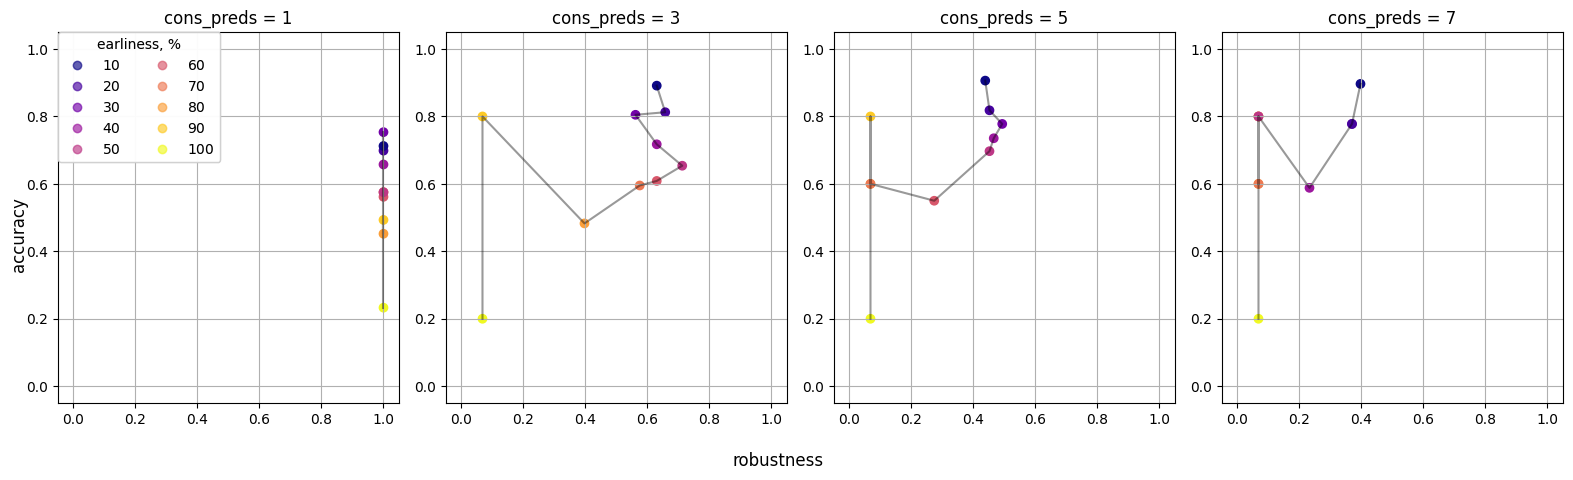

In [200]:
plot_changes(r_teaser, param_name='cons_preds', height=4)

Here we see the same behavior on the first subplot. But in other cases model demonstrates the greater hesitation for the most early points. Further, the greater amount of consecutive predictions is required, the lefter point shift. So, one may conclude the OneClassSVM approach is not as stable as the thresholding is or the underfitting of classifiers is present.

### EconomyK

EconomyK algorithm widens the boundaries of basic classsifiers queue with the estimation of prefixes clustering results. Clustering is conducted with fast KMeans during the training phase and for prefixes the required length is cropped from centroids' coordinates. 

The accessed values of probability of being labeled as a cluster member is recalculated and used to ensure the slave prediction. 

In [ ]:
import fedot_ind.core.models.early_tc.economy_k as ECONOMYK
params = [1e-3, 1, 1e5, 1e7]
r_economy_k = eval_param_influence(ECONOMYK.EconomyK,
                               'lambda_', params,
                               prediction_mode='all', interval_percentage=INTEVAL_PERCENTAGE)

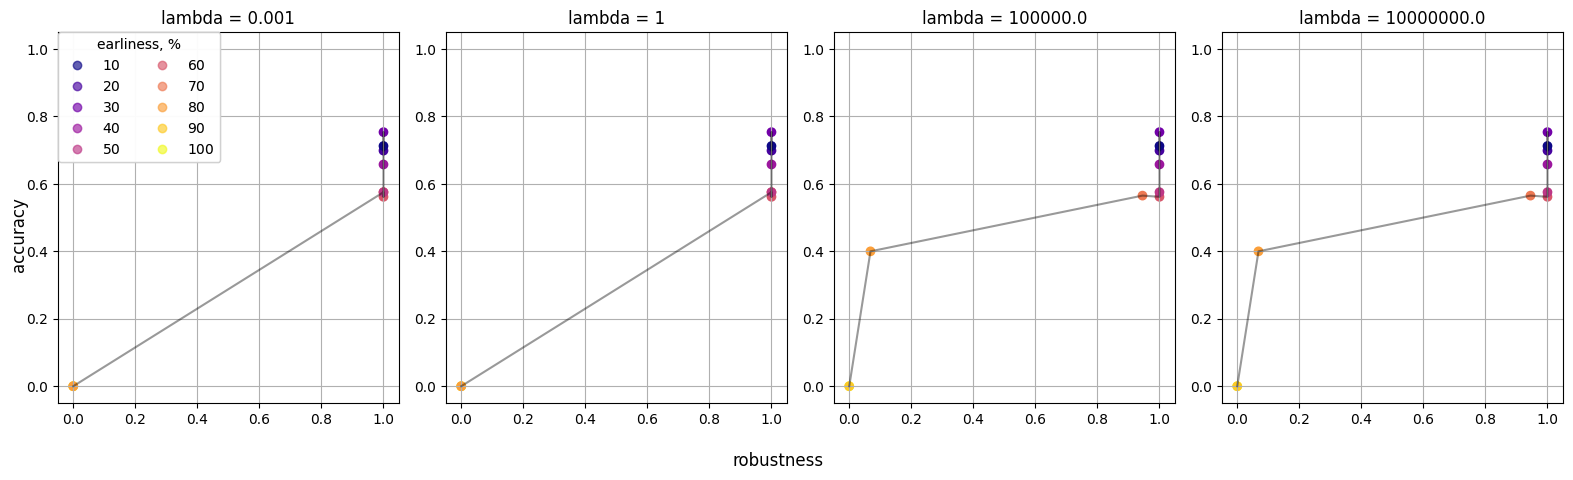

In [201]:
plot_changes(r_economy_k, param_name='lambda', height=4)

Extremely interesting behaviour is registered for EconomyK model: its confidence rockets with the earliness drop resulting in acceptance of almost all the predictions, however, the resulting accuracy is not as large as it is expected for such level of confidence.

### ECEC

The definition of a common confidence threshold for different classifiers lacks of logic since the ratio of available classes and features changes along the time series length and effect the classifiers' performances. ECEC model aims to eliminate this drawback evaluating the confidence thresholds separately and automatically. 

Obtained values are stored in *confidence_thresholds* attribute after training.

In [ ]:
from fedot_ind.core.models.early_tc import ecec as ECEC
reload(ECEC)
accuracy_importance = [0, 0.1, 0.2, 1]
r_ecec = eval_param_influence(ECEC.ECEC,
                               'accuracy_importance', accuracy_importance,
                               prediction_mode='all', interval_percentage=INTEVAL_PERCENTAGE)

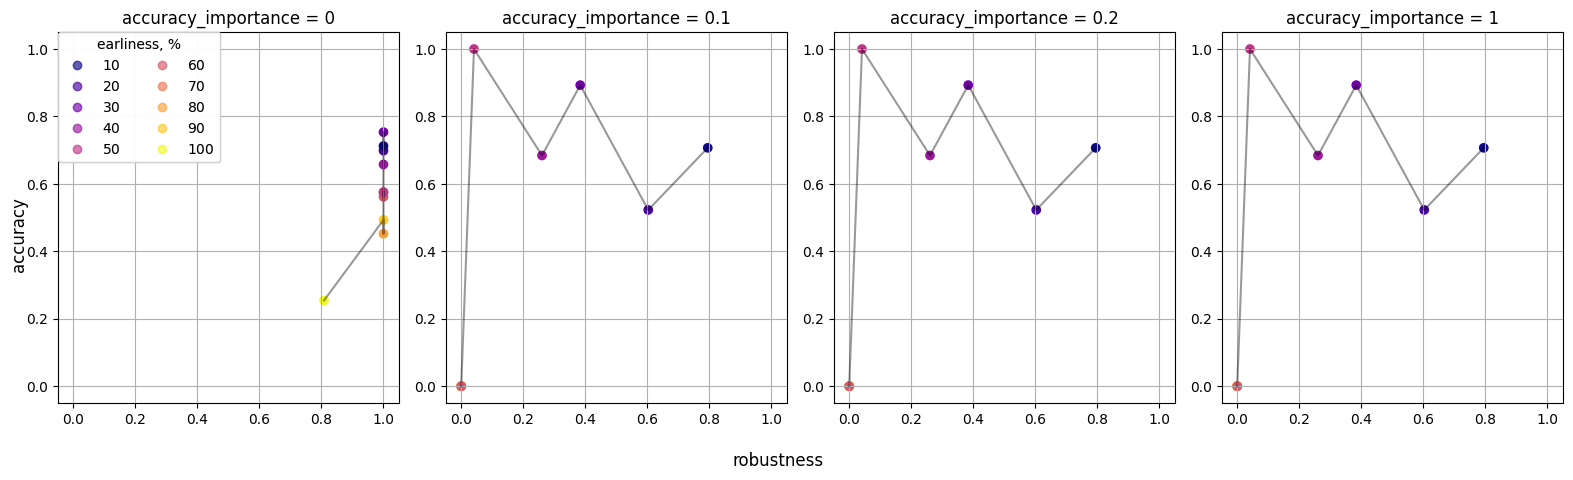

In [202]:
plot_changes(r_ecec, param_name='accuracy_importance', height=4)

Surprisingly, ECEC demonstrates very subtle sensitivity to the only tunable fitting huperparameter *accuracy_importance* which results in a flattend values in case only aerliness is considered, and downsliding dependency for other values which may be an evidence of overestimation of parameters. 

Moreover, for last subplots, the first 5 estimation points are set to (0, 0) since no objects passed over the thresholds.

## API launch

In [9]:
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from copy import deepcopy
from tqdm.autonotebook import tqdm

Let's prepare some configuration dictionaries

In [102]:
series_length = train_data.features.shape[-1]

interval_percentage = 5
consecutive_predictions = 2
transform_score = True
prediction_mode = 'all'
accuracy_importance = 0.5
common_dict = {
        'prediction_mode': prediction_mode,
        'interval_percentage': interval_percentage,
        'transform_score': transform_score,
        'accuracy_importance': accuracy_importance,
}
models = {
    'economy_k': {
        'lambda': 100000,
    },
    'ecec': {},
    'teaser': {},
    'proba_threshold_etc': {
        'probability_threshold': 0.8,
    },
}
for model in models:
    models[model] |= common_dict
prediction_idx = (np.linspace(0, 1, 21) * series_length).astype(int)
earliness = 1 - prediction_idx / series_length

results = {model: [None] * len(prediction_idx) for model in models}

In [128]:
with IndustrialModels():
    repo = IndustrialModels().setup_repository()
    for model, params in models.items():
        pipeline = PipelineBuilder().add_node(model, params=params).build()
        pipeline.fit(train_data)
        prediction = pipeline.predict(test_data).predict
        prediction, scores = prediction
        prediction = prediction.argmax(-1)
        scores = scores[..., 0]
        results[model] = ETSCPareto(
            yte, prediction, scores, reduce=False, metric_list=('accuracy',).metric()
        )


In [144]:
import matplotlib.pyplot as plt

def plot_bicrit_metric(metrics: dict, select=None):
    plt.figure(figsize=(10, 10))
    for model, metric in metrics.items():
        selection = metric.iloc[select, :]
        sizes = ((np.arange(selection.shape[0]) * 2)[::-1]) ** 1.5 + 10
        plt.plot(selection.robustness, selection.accuracy, alpha=0.3)
        plt.scatter(x=selection.robustness, 
                    y=selection.accuracy,
                    s=sizes, 
                    label=model)
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
    plt.xlabel('Robustness')
    plt.ylabel('Accuracy')
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid(True)


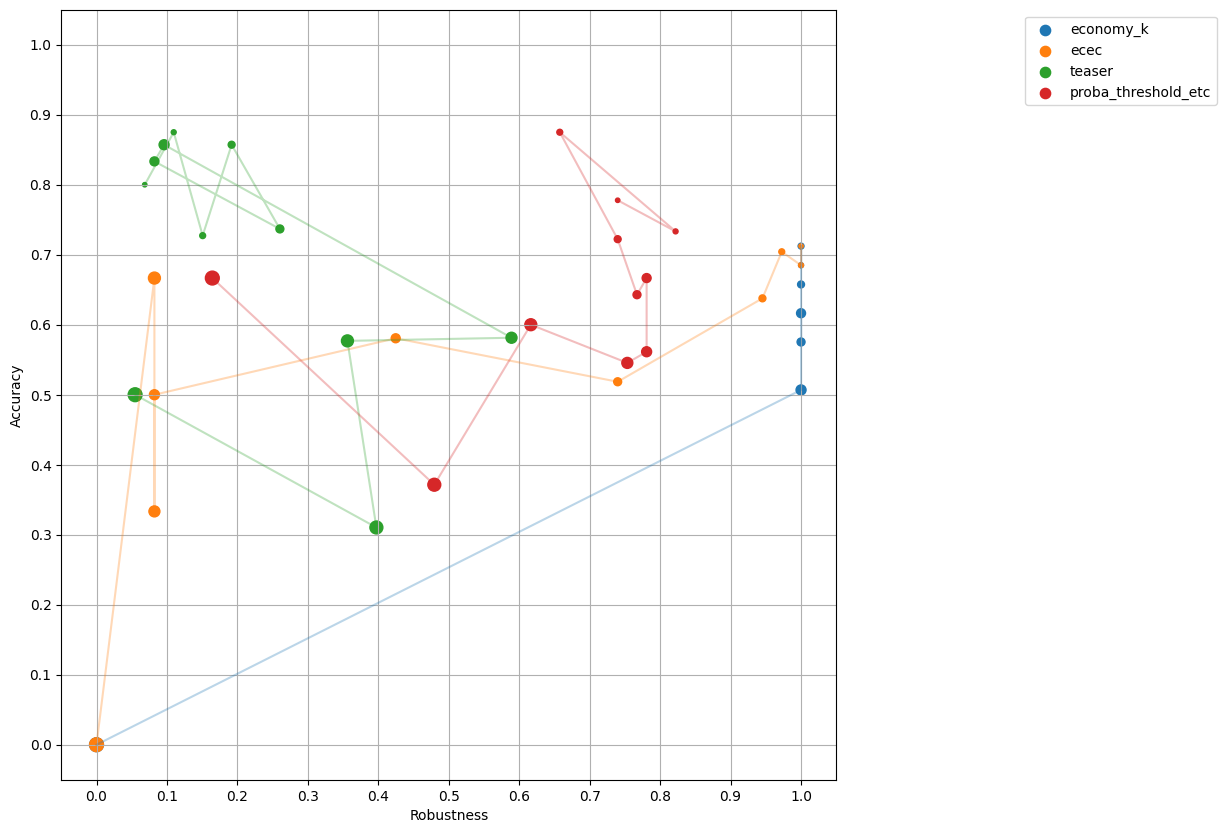

In [145]:
plot_bicrit_metric(results, select=slice(None, None, 2))